# Shor's Algorithm Based on MindSpore Quantum

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_shor_algorithm.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_shor_algorithm.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/case_library/shor_algorithm.ipynb)

## Introduction to Shor's Algorithm

The time complexity of Shor's algorithm to decompose an integer $N$ on a quantum computer is $logN$, which is almost exponential $e$ speedup over the most efficient known classical factorization algorithm, and this speedup may break the modern cryptography such as RSA on a quantum computer.

## Basic Idea of Shor's Algorithm

Shor's algorithm aims to solve the problem: given an integer $N$, find its prime factors. That is, for a given large number $N$, determine two prime factors $p1$ and $p2$ in polynomial time to satisfy $p1\cdot p2=N$. Before introducing the Shor's algorithm, let's learn some basic knowledge of number theory.

Factorization involves some knowledge in number theory, and it is possible to reduce the factorization problem to the function

$$
f(x) = a^x \bmod N
$$

where $a$ and $N$ are relatively prime, otherwise a factor can be obtained immediately by calling $gcd(a,N)$. Since the function $f(x)$ has a period of $r$, $f(x)=f(x+r)$ is satisfied. In this case, we can get

$$
a^x = a^{x+r} \bmod N, \forall x
$$

Set $x=0$, we can get $a^r=1+qN$, where $q$ is an integer,

$$
a^r-1=(a^{r/2}-1)(a^{r/2}+1)=qN
$$

It indicates that the factors of $N$ can be found through finding greatest common divisor.

Therefore, the main idea of Shor's algorithm is to transform the problem of factoring large numbers into the problem of finding the function's period. Since we can use the superposition principle to perform parallel computing in quantum computing, we can quickly find the period $r$ of the function $f(x)$ through quantum algorithms (for specific principles and steps, please refer to the `period finding algorithm` in this document ). In general, we need to implement the function: $f(|x\rangle)=a^{|x\rangle} \bmod N$ in the quantum circuit. We can construct a unitary matrix $U_{a,N} $ where $U_{a,N}|x\rangle |y\rangle \rightarrow |x\rangle |y \oplus f(x) \rangle$, and then using Quantum Fourier Transform to find the period $r$ which satisfies $a^r\equiv 1( \bmod N)$.

Taking $N=15$ as an example, the steps of Shor's algorithm is introduced as follows,

1. Randomly choose a number, such as $a=2(<15)$

2. Find the greatest common divisor, $\rm gcd(a,N)=gcd(2,15)=1$

3. Find the period of the function $f(x)=a^x \bmod N$, so that $f(x+r)=f(x)$

4. Running the quantum circuit we can get $r=4$

5. Find the greatest common divisor, $\gcd(a^{r/2}+1,N)=\gcd(5,15)=5$

6. Find the greatest common divisor, $\gcd(a^{r/2}-1,N)=\gcd(3,15)=3$

7. Hence, the prime factor of $N=15$ are 3 and 5, and the decomposition operation is complete.

The quantum circuit of Shor's algorithm is shown as follows:

![shor's algorithm circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/shor_algorithm_circuit.png)

## Implementing Shor's Algorithm Using MindSpore Quantum

First, we need to import some required modules.

In [1]:
#pylint: disable=W0611
import numpy as np
from fractions import Fraction
from mindquantum.core.gates import X, H, UnivMathGate, Measure
from mindquantum.core.circuit import Circuit, UN
from mindquantum.algorithm.library import qft
from mindquantum.simulator import Simulator

From the basic idea of Shor's algorithm, we can see that the main part of Shor's algorithm is period finding subroutine processed by quantum computers, and the most difficult part of the period search algorithm is the operator $U$ which convert the state $|x\rangle |y\rangle$ into $|x\rangle |y \oplus f(x) \rangle$. The quantum circuit structure of this operator is more complicated. Therefore, we will first calculate the operator $U$ through a classical computer and use it as Make an Oracle so that this document can demonstrate Shor's algorithm as a whole and intuitively.

### Constructing the Oracle

Shor's algorithm's core quantum part is the period finding, and its key lies in efficiently implementing a unitary operator $U_{a,N}$. This operator acts on two quantum registers (register 1 storing the exponent $x$, register 2 storing auxiliary results $y$) and performs reversible modular exponentiation.

Specifically, the unitary operator $U_{a,N}$ we need to construct must precisely implement the following transformation for all possible input basis states $|x\rangle|y\rangle$:

$$
U_{a,N} |x\rangle |y\rangle = |x\rangle |y \oplus (a^x \bmod N)\rangle
$$

Where:

* $|x\rangle$ is a register of $q$ qubits, used to store the exponent from $0$ to $Q-1$ ($Q=2^q \ge N$).
* $|y\rangle$ is also a register of $q$ qubits, used to store intermediate results.
* $a^x \bmod N$ is the result of the classical modular exponentiation.
* $\oplus$ represents the bitwise XOR operation. XOR is chosen to facilitate the construction of the corresponding unitary matrix (a permutation matrix) and ensure the operation's reversibility.

Although the complete $|y \oplus f(x)\rangle$ transformation requires more complex quantum circuits (like quantum modular adders and multipliers), we can directly construct this $2^{2q} \times 2^{2q}$ unitary matrix $U_{a,N}$. This matrix is essentially a permutation matrix that uniquely maps each input basis state $|x\rangle|y\rangle$ to the output basis state $|x\rangle|y \oplus (a^x \bmod N)\rangle$.

**Implementation Steps:**

1. **Determine the number of qubits:**
    * **Target register (register 2):** Needs $q = \lceil \log_2 N \rceil$ qubits to store $a^x \bmod N$ (range from $0$ to $N-1$).
    * **Control register (register 1):** Stores the exponent $x$. To ensure the Quantum Fourier Transform yields the period $r$ with high probability, the number of qubits $t_q$ should satisfy $2^{t_q} \ge N^2$, i.e., $t_q \ge 2 \log_2 N$. Hence, in theory we choose $t_q = 2q$, where $Q_{ctrl} = 2^{t_q}$ is the size of the control register's state space.
    * **Simplified approach in this tutorial:** For demonstration and resource considerations, we use $t_q = q$ qubits for the control register (thus $Q_{ctrl} = 2^q$), giving a total of $n_{total} = q + t_q = 2q$ qubits. While this works for $N=15$ and $a=2$, for larger $N$ it significantly reduces the probability of finding the correct period $r$, possibly requiring more trials or only yielding a factor of $r$, or failing.
    * **Note on notation:** In the remainder of this tutorial, whenever we refer to the control register's qubit count or its corresponding state space size $Q$, we are referring to the simplified $q$ and $Q=2^q$.

2. **Calculate modular exponentiation values:** For all $x \in [0, Q-1]$ (where $Q = 2^q$), compute $f(x) = a^x \bmod N$.

3. **Construct the Unitary Matrix $U$:** Create a $2^n \times 2^n$ zero matrix. For each basis state $|x\rangle|y\rangle$ ($x,y \in [0,Q-1]$), compute:
    * $idx_{in} = (x \ll q) + y$ and $idx_{out} = (x \ll q) + (y \oplus f(x))$.
    * Set $U[idx_{out}, idx_{in}] = 1$. This permutation matrix is unitary.

4. **Create `UnivMathGate`:** Instantiate a `UnivMathGate` with the constructed matrix $U$ and apply it to `register2 + register1` (ensuring $y$ corresponds to the lower bits).

**Example: N=15, a=2:**

We need $q=4$ qubits, because $2^4 = 16 \ge 15$. The total number of qubits $n = 2q = 8$. The Hilbert space dimension is $2^8 = 256$.

We can obtain $x$ and $f(x)$:

In [2]:
q = 4  # number of qubits
N = 15
a = 2
x = []
f = []
for i in range(2**q):
    x.append(i)
    f.append(a**i % N)
print('x: ', x)
print('f(x): ', f)

x:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
f(x):  [1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8]


We can observe that $f(x)$ is indeed a periodic function.

Next, we construct the unitary gate corresponding to the modular exponentiation operation:

In [3]:
def create_mod_exp_oracle(N, a, register1, register2):
    """
    Construct the gate for modular exponentiation U|x>|y> = |x>|y XOR (a^x mod N)>.

    Args:
        N (int): The number to be factored.
        a (int): The random base chosen in Shor's algorithm.
        register1 (list): Qubit indices for register 1 (requires q qubits where 2^q >= N).
        register2 (list): Qubit indices for register 2 (requires q qubits where 2^q >= N).

    Returns:
        UnivMathGate: The gate corresponding to the modular exponentiation U|x>|y> = |x>|y XOR (a^x mod N)>.
    """
    q = len(register1)
    n_qubits = 2 * q
    dim = 2**n_qubits
    Q = 2**q
    U_matrix = np.zeros((dim, dim), dtype=complex)

    # Precompute f(x) = a^x mod N
    fx_map = {}
    for x in range(Q):
        fx_map[x] = pow(a, x, N)

    # Construct the permutation matrix
    for x in range(Q):       # Iterate through states |x> of register 1
        fx = fx_map[x]
        for y in range(Q):   # Iterate through states |y> of register 2
            idx_in = (x << q) + y         # Index of |x>|y>
            idx_out = (x << q) + (y ^ fx) # Index of |x>|y XOR f(x)>
            U_matrix[idx_out, idx_in] = 1

    # Verify unitarity
    assert np.allclose(U_matrix @ U_matrix.conj().T, np.eye(dim))

    # Create the gate
    # Note: The order in .on() is register2 + register1 to match the matrix construction where y is the lower bits
    oracle_gate = UnivMathGate(f'ModExp({a},{N})', U_matrix).on(register2 + register1)
    return oracle_gate

Now, the gate constructed by the `create_mod_exp_oracle()` function can perform modular exponentiation on the quantum state $|x\rangle$ in register 1 and store the result $a^{|x\rangle} \bmod N$ in register 2.

#### Little-Endian Convention and Qubit Allocation

MindQuantum uses the little-endian convention to represent quantum states. In this convention, the index of a qubit corresponds to its significance in representing a numerical value: **the qubit with the lowest index (index 0) represents the Least Significant Bit (LSB)**. Therefore, an N-qubit state is typically written as $|q_{N-1}...q_1q_0\rangle$, where $q_0$ is the LSB.

To naturally align MindQuantum's little-endian convention with the quantum state notation $|x\rangle |y\rangle$ used earlier, we perform the following qubit allocation:

* **Register 1 (logical value $x$):** Qubits $q$ to $2q-1$ (higher-indexed qubits).
* **Register 2 (logical value $y$):** Qubits $0$ to $q-1$ (lower-indexed qubits).

This means that although register 1 might be depicted above register 2 in schematic diagrams of Shor's algorithm, the circuit diagram drawn by MindQuantum will show register 2 above register 1. Quantum gates and measurements will be adjusted accordingly.

This allocation ensures that in MindQuantum's state vector representation, the qubits associated with the logical value $y$ (corresponding to the lower part of the numerical value) have lower indices, while the qubits associated with the logical value $x$ (corresponding to the higher part) have higher indices. The advantage is that the index of the state vector for the entire quantum state directly maps to the integer value $x \cdot 2^q + y$, simplifying the matrix construction process for operations like `UnivMathGate`. It's important to emphasize that this index-based allocation does not change the core logical function of the Oracle, which is to modify the value of register 2 ($y$) based on the value of register 1 ($x$).

#### Verify the Oracle

We can verify if the Oracle works as expected by applying it to a specific initial state. For example, let's compute $U |8\rangle |0\rangle$. We expect to obtain $|8\rangle |0 \oplus (2^8 \bmod{15})\rangle$.

Since $2^8 = 256$, and $256 \bmod{15} = 1$, we have $0 \oplus 1 = 1$. Therefore, we expect the final state to be $|8\rangle|1\rangle$.

$|8\rangle$ corresponds to binary `1000`.
$|1\rangle$ corresponds to binary `0001`.
So the final state $|8\rangle|1\rangle$ corresponds to binary `1000 0001` (with register 1 as the higher bits).

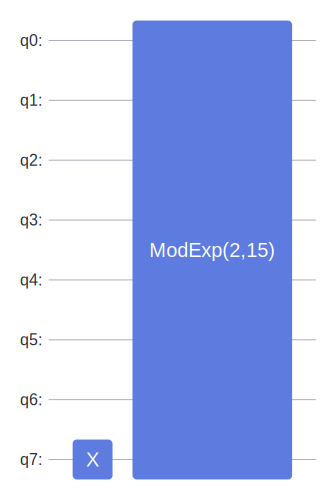

In [4]:
#pylint: disable=W0104
register1 = range(4, 8)
register2 = range(4)
circuit = Circuit(X.on(7))  # Create circuit, initialize state to |1000>|0000>, i.e., x=8, |8>|0>
circuit += create_mod_exp_oracle(15, 2, list(register1), list(register2))  # Apply the oracle operator
circuit.svg() # Print the circuit diagram

In [5]:
print(circuit.get_qs('mqvector', ket=True))  # Print the final state

1¦10000001⟩


The result in register 1 is `1000`, and the result in register 2 is `0001`. We previously calculated $f(8)=2^8 \bmod 15=1$. Therefore, the output is correct.

Next, we need to implement the period finding algorithm.

### Period Finding Subroutine

1. In register 1, we need $q>log_2 N$ qubits to record the binary number of the variable $x \in [0,N-1]$, and we also need $q$ qubits in register 2 to record $f (x)=a^x \bmod N, x \in [0,N-1]$ binary form. At this time, register 1 and register 2 can respectively record the integers of $[0, Q-1]$, where $Q=2^q>N$.
2. The [Hadamard](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate is applied to all bits in register 1, and the bits in register 1 are in a uniform superposition state of all integers in $[0,Q-1]$

    $$
    |\psi\rangle=\frac{1}{\sqrt{Q}}\sum_{x=0}^{Q-1}|x\rangle
    $$

3. Perform function operation $a^{|\psi\rangle} \bmod N$ on the state $|\psi\rangle$ stored in register 1, and store the result in register 2. This step is completed by the previously constructed U_operator . Due to the direct operation on the superposition state $|\psi\rangle$, this step can completed in one step, which shows the Quantum Advantage - parallel computing. At this time, the state stored in the circuit is an entangled state, which can be expressed as

    $$
    \sum_{x=0}^{Q-1}|x\rangle|f(x)\rangle=\sum_{i=0}^{r-1}(|i\rangle+|i+r\rangle+| i+2r\rangle+...) |f(i)\rangle
    $$

4. Perform an inverse Quantum Fourier Transform (iQFT) on register 1. This transform uses a $Q$-order unit root $\omega = e^{2\pi i/Q}$, which evenly distributes the amplitude of any given state $|x\rangle$ on $Q$ states of $|y\rangle$. As shown in step 3, the equivalent states of $|i\rangle$, $|i+r\rangle$, etc. in register 1 are all entangled with the same state $|f(i)\rangle$ in register 2. Due to quantum interference, the final measurement probability for a state $|y\rangle$ is larger when the phase factor $e^{2\pi i ry / Q}$ is closer to 1 (i.e., points towards the positive real axis). In other words, the measured state $|y\rangle$ has a high probability that $ry/Q$ is close to an integer $c$. For a more detailed mathematical description, please refer to the link: <https://en.wikipedia.org/wiki/Shor%27s_algorithm>.
5. Measure register 1 to get the binary string. Convert the binary string to the decimal number $y$. At this point, $y/Q \approx c/r$, where $c$ is an unknown integer. Use the continued fraction algorithm to find the irreducible fraction that approximates $y/Q$ (with denominator no larger than $N$). The denominator of this fraction is the period candidate $r$. However, there might be another fraction closer to $y/Q$, or $c$ and $r$ might share a common factor, resulting in $r$ being a factor of the true period. In such cases, the calculation fails, and we need to repeat the process.

Taking the example of $N=15, a=2$ again, in `Constructing the Oracle`, we calculated each $f(x)$, from which we can directly see that the function period is 4. Now we can build the corresponding period-finding subroutine and run 100 simulations to see what we get.

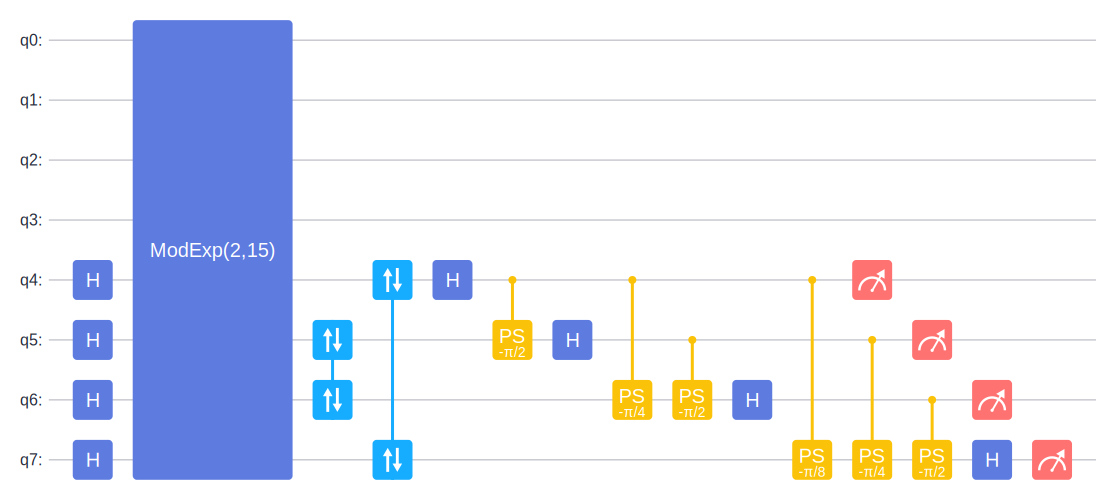

In [6]:
#pylint: disable=W0104
circuit = Circuit() # Create a quantum circuit
register1 = range(4, 8) # Set qubits 4-7 to register 1
register2 = range(4)    # Set qubits 0-3 to register 2

circuit += UN(H, register1) # Apply H gate to all bits in register 1

# Perform the modular exponentiation operation using the Oracle
# U|x>|y> -> |x>|y XOR a^x mod N>
circuit += create_mod_exp_oracle(15, 2, list(register1), list(register2))

# Perform the inverse Quantum Fourier Transform on register 1.
# Note the qubit order for QFT: [::-1] reverses the register order for correct transformation.
circuit += qft(register1[::-1]).hermitian()
circuit += UN(Measure(), register1) # Measure register 1

circuit.svg() # Draw a circuit diagram

From the circuit diagram, we can intuitively see that the entire period-finding circuit consists of four parts: Superposition Generation $\rightarrow$ Function Operation $\rightarrow$ Inverse Fourier Transform $\rightarrow$ Measurement.

Next, run the circuit 100 times and observe the measurement results.

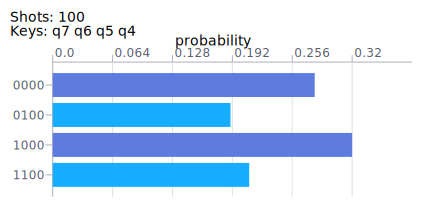

In [7]:
# pylint: disable=W0104
sim = Simulator('mqvector', circuit.n_qubits) # Create a quantum circuit simulator

# Simulate the circuit 100 times, print the measurement results, set the random seed to a random integer within 100
result = sim.sampling(circuit, shots=100, seed=np.random.randint(100))

result.svg()

From the statistical results, we can see that only 4 states can be measured in the last register 1, which are $y=[0,4,8,12]$. This is because $\omega^{2\pi iry/Q}, (Q=16)$ is exactly 1 when $y$ takes these four values, while other states cancel out to zero probability amplitude due to quantum interference. Substituting the measurement results into $\frac{y}{Q}\sim\frac{c}{r}$, we can see that the formula indeed holds. We have about a 50% probability of getting the correct period $r$, but about a 25% probability of getting a factor of $r$, and a 25% probability of getting the 0 state. The latter two cases require recalculation.

Next we are going to construct a general period-finding algorithm.

In [8]:
def period_finder(N, a, q):
    circuit = Circuit()  # Create a quantum circuit
    register1 = range(q, 2 * q)  # Set qubits q to 2q-1 for register 1
    register2 = range(q)  # Set qubits 0 to q-1 for register 2

    circuit += UN(H, register1)  # Apply H gate to all qubits in register 1

    # Apply the modular exponentiation Oracle as one big U gate
    circuit += create_mod_exp_oracle(N, a, list(register1), list(register2))

    circuit += qft(register1[::-1]).hermitian()  # Perform inverse QFT on register 1 (note reversed order)
    circuit += UN(Measure(), register1)  # Measure register 1

    sim = Simulator('mqvector', circuit.n_qubits)  # Create a quantum circuit simulator

    # Simulate the circuit once, collect the measurement result, random seed in [0,100)
    result = sim.sampling(circuit, seed=np.random.randint(100), shots=1)

    # result.data is a dict where key is measured binary string, value is count (1)
    result = list(result.data.keys())[0]  # Get the measured binary string
    result = int(result, 2)  # Convert the result from binary to decimal

    # Use continued fraction to approximate result/2**q with denominator <= N
    eigenphase = float(result / 2**q)
    f = Fraction.from_float(eigenphase).limit_denominator(N)
    r = f.denominator  # The denominator is the period candidate

    # Verify if r is the actual period
    if pow(a, r, N) == 1:
        return r
    return None

### Classic Computer Part

The classical computer part is responsible for transforming the factorization problem into the problem of finding function period. The specific steps are as follows:

1. Randomly pick an integer $a$ less than $N$, use the gcd algorithm to verify whether $a$ and $N$ are mutually prime, if there is a common factor between $a$ and $N$, then we directly get one of $N$'s factor, output the result.

2. Determine the number of qubits $q$ required to store the binary representation of $N$ (such that $2^q \ge N$).

3. Use the period finding algorithm (quantum part) to get the period $r$ of the function $f(x)=a^x \bmod N$.

4. Determine whether $r$ is an even number. If not, go back to step 1.

5. Calculate $a^{r/2}+1$ and $a^{r/2}-1$. Compute the greatest common divisor (gcd) of each of these with $N$. One of these gcds might be a non-trivial factor of $N$. However, it's possible that $a^{r/2}+1$ is divisible by $N$, or the gcd is 1 or N. If a non-trivial factor is found, output the factors. Otherwise (e.g., if $r$ is odd or the gcds are trivial), go back to step 1.

In [9]:
#pylint: disable=C0121,R1705
def shor(N):
    while True:
        a = np.random.randint(N - 2) + 2  # Generate a random integer a in [2, N-1]
        b = np.gcd(a, N)  # Compute gcd(a, N)
        if b != 1:
            return b, int(N / b)  # Found a factor

        # Determine the number of bits q such that 2**q >= N
        q = 0
        while True:
            Q = 2**q
            if Q >= N:
                break
            q += 1

        print(f'Trying base a = {a} with {q} qubits for x register...')
        r = period_finder(N, a, q)  # Get the period r

        # If r is not even or not found, retry
        if r is None or r % 2 != 0:
            continue
        break

    # Compute potential factors
    c = np.gcd(a**(r // 2) + 1, N)
    d = np.gcd(a**(r // 2) - 1, N)
    if c != 1 and N % c == 0:
        return c, int(N / c)
    else:
        return d, int(N / d)

It should be noted that since we directly constructed the oracle as a huge unitary matrix gate, the simulation time has increased significantly. Therefore, for cases where $N>55$, it may take a long time to get the result.
Furthermore, due to the simplified control register qubit count mentioned earlier, the probability of finding the correct period $r$ decreases for larger values of $N$.

Finally, let's try to factor $N=35$ using the Shor's algorithm we have written.

In [10]:
N = 35
print("Factoring N = p * q =", N)

p, q = shor(N)

print("p =", p)
print("q =", q)


Factoring N = p * q = 35
p = 5
q = 7


As we can see from the results, we successfully decomposed 35 into two prime factors 5 and 7.

So far, we have successfully implemented the Shor's algorithm using MindSpore Quantum.

In [11]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.10.0
scipy,1.15.2
numpy,1.26.4
System,Info
Python,3.10.16
OS,Darwin arm64
Memory,17.18 GB
CPU Max Thread,10
Date,Fri May 16 19:22:48 2025
